### Task : Classification ( Linear SVM Classifier -> Multiclass (OneVsAll) )
#### Input Features (Predictor Variables) : x1, x2 (2)
#### Output (Response Variable(s)) : Class (0 or 1 or 2)

### Importing the necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, model_selection, preprocessing, base, metrics, datasets, pipeline
from joblib import dump, load

### Collecting, Analyzing and Visualizing data

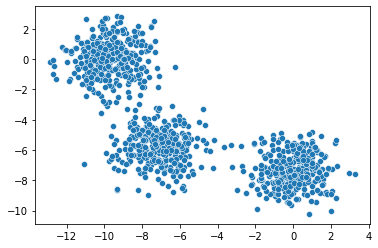

In [10]:
# Creating Blobs

X, y = datasets.make_blobs(n_samples = 1000, n_features = 2, centers = 3, cluster_std = 1.1, random_state = 9)

sns.scatterplot(x = X[:, 0], y = X[:, 1])
plt.show()

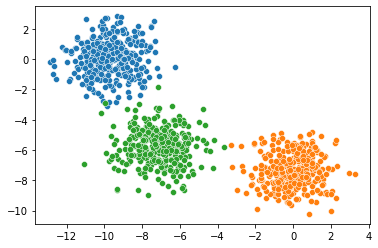

In [13]:
X0 = X[y == 0]
X1 = X[y == 1]
X2 = X[y == 2]

sns.scatterplot(x = X0[:, 0], y = X0[:, 1])
sns.scatterplot(x = X1[:, 0], y = X1[:, 1])
sns.scatterplot(x = X2[:, 0], y = X2[:, 1])
plt.show()

In [16]:
# Creating a data frame (for analysis)

df = pd.DataFrame(X, columns = ['x1', 'x2'])
df['target'] = y
df.head()

,x1,x2,target
0,-0.293401,-8.732515,1
1,-6.290629,-5.113369,2
2,-6.807757,-4.221194,2
3,-7.117253,-5.856936,2
4,-7.631294,-6.197516,2


In [18]:
df['target'].value_counts()

0    334
1    333
2    333
Name: target, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   target  1000 non-null   int32  
dtypes: float64(2), int32(1)
memory usage: 19.7 KB


In [20]:
df.describe()

,x1,x2,target
count,1000.000000,1000.000000,1000.000000
mean,-5.668217,-4.322663,0.999000
std,4.239546,3.372532,0.817109
min,-12.865224,-10.222562,0.000000
25%,-9.112312,-7.028159,0.000000
50%,-7.169879,-5.551185,1.000000
75%,-0.816456,-0.680427,2.000000
max,3.269618,2.838967,2.000000


In [21]:
df.iloc[:, :-1].corr()

,x1,x2
x1,1.000000,-0.751316
x2,-0.751316,1.000000


In [27]:
num_attr = df.columns[:-1]
target = df.columns[-1]

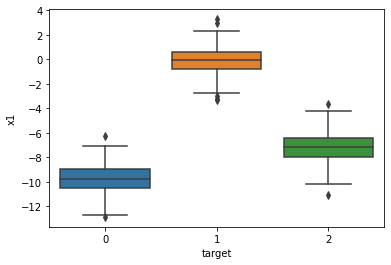

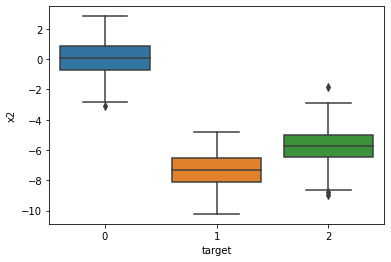

In [30]:
# Boxplot

for var in num_attr:
    sns.boxplot(x = target, y = var, data = df)
    plt.show()

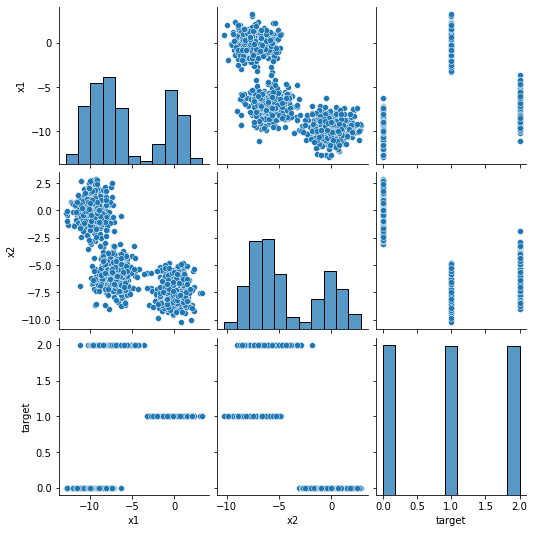

In [26]:
sns.pairplot(df)
plt.show()

### Data Preprocessing and Preparation

In [34]:
# Creating a Transformation Pipeline for Feature Scaling

p = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
])

In [35]:
# Stratified Splitting

strat_split = model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 3)

for train_index, test_index in strat_split.split(df, df[[target]]):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

In [36]:
print(train_set.shape, test_set.shape)

(800, 3) (200, 3)


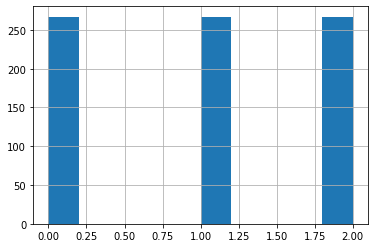

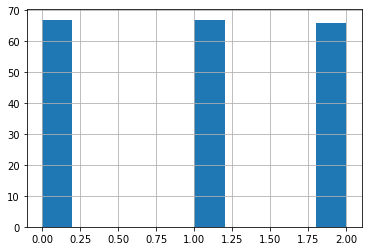

In [37]:
# Checking whether the samples are uniformely distributed

train_set['target'].hist()
plt.show()

test_set['target'].hist()
plt.show()

In [38]:
# Scaling the features

train_set_scaled = p.fit_transform(train_set.iloc[:, :-1])

train_set_scaled = np.c_[train_set_scaled, train_set.iloc[:, -1]]

In [39]:
X_train = train_set_scaled[:, :-1]
y_train = train_set_scaled[:, -1].astype(int)

### Training the Model and Evaluating it's Performance

In [86]:
# Implementing LinearSVC from scratch

class SVMClassifier:
    
    def __init__(self, lam = 0.001, lr = 0.01, n_iter = 100):
        self.lam = lam
        self.lr, self.n_iter = lr, n_iter
        self.w = self.b = None
        
    def fit(self, X, y):
        n, n_features = X.shape
        y = np.where(y == 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.n_iter):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(self.w, x_i) - self.b) >= 1
                if condition: 
                    dw = 2 * self.lam * self.w
                else:
                    dw = 2 * self.lam * self.w - np.dot(x_i, y[idx])
                    db = y[idx]
                self.w -= self.lr * dw
                self.b -= self.lr * db
        
    def predict(self, X):
        y_pred = (np.dot(X, self.w) - self.b > 0).astype(int)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        acc = np.sum(y == y_pred) / len(y)
        return acc

In [87]:
y_train_all = []
for i in range(3):
    y_train_all.append((y_train == i).astype(int))
    
y_train0, y_train1, y_train2 = y_train_all

In [88]:
# Tranining 3 Binary Classifiers (One for each class)

clf0 = SVMClassifier()
clf1 = SVMClassifier()
clf2 = SVMClassifier()

clf0.fit(X_train, y_train0)
clf1.fit(X_train, y_train1)
clf2.fit(X_train, y_train2)

y_train_pred0 = clf0.predict(X_train)
y_train_pred1 = clf1.predict(X_train)
y_train_pred2 = clf2.predict(X_train)

train_acc0 = np.sum(y_train0 == y_train_pred0) / len(y_train0)
train_acc1 = np.sum(y_train1 == y_train_pred1) / len(y_train1)
train_acc2 = np.sum(y_train2 == y_train_pred2) / len(y_train2)

print("Train Accuracy (Class 0 Classifier) :", train_acc0)
print("Train Accuracy (Class 1 Classifier) :", train_acc1)
print("Train Accuracy (Class 2 Classifier) :", train_acc2)

scores = np.array([train_acc0, train_acc1, train_acc2])

Train Accuracy (Class 0 Classifier) : 0.9925
Train Accuracy (Class 1 Classifier) : 0.99625
Train Accuracy (Class 2 Classifier) : 0.915


In [89]:
# Combining individual predictions

n_classes = len(np.unique(y_train))

y_train_pred_all = np.stack([y_train_pred0, y_train_pred1, y_train_pred2], axis = 1)

y_train_pred, i = np.zeros(len(y_train_pred_all)).astype(int), 0

for x in y_train_pred_all:
    if not any(x):
        y_train_pred[i] = np.argmin(scores)
    else:
        y_train_pred[i] = np.argmax(x + scores)
    i += 1

In [90]:
acc = np.sum(y_train == y_train_pred) / len(y_train)

print("Overall Training Accuracy :", acc)

Overall Training Accuracy : 0.98875


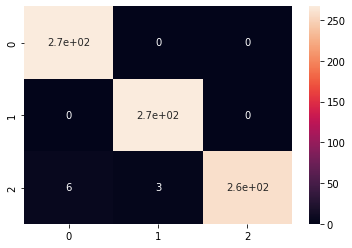

In [92]:
# Confusion Matrix

conf_matrix = metrics.confusion_matrix(y_train, y_train_pred)

sns.heatmap(conf_matrix, annot = True)
plt.show()

In [93]:
# Classification Metrics

precision = metrics.precision_score(y_train, y_train_pred, average = 'weighted')
recall = metrics.recall_score(y_train, y_train_pred, average = 'weighted')
f1 = metrics.f1_score(y_train, y_train_pred, average = 'weighted')

print("Precision :", precision)
print("Recall or Sensitivity :", recall)
print("F1 Score :", f1)

Precision : 0.9889566567261735
Recall or Sensitivity : 0.98875
F1 Score : 0.9887057521139297


In [94]:
# Classification Report

clf_report = metrics.classification_report(y_train, y_train_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       267
           1       0.99      1.00      0.99       266
           2       1.00      0.97      0.98       267

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



### Validating the model

In [95]:
test_set_scaled = p.fit_transform(test_set.iloc[:, :-1])

test_set_scaled = np.c_[test_set_scaled, test_set.iloc[:, -1]]

In [96]:
X_test = test_set_scaled[:, :-1]
y_test = test_set_scaled[:, -1].astype(int)

In [99]:
y_test_all = []
for i in range(3):
    y_test_all.append((y_test == i).astype(int))
    
y_test0, y_test1, y_test2 = y_test_all

In [100]:
y_test_pred0 = clf0.predict(X_test)
y_test_pred1 = clf1.predict(X_test)
y_test_pred2 = clf2.predict(X_test)

test_acc0 = np.sum(y_test0 == y_test_pred0) / len(y_test0)
test_acc1 = np.sum(y_test1 == y_test_pred1) / len(y_test1)
test_acc2 = np.sum(y_test2 == y_test_pred2) / len(y_test2)

print("Test Accuracy (Class 0 Classifier) :", test_acc0)
print("Test Accuracy (Class 1 Classifier) :", test_acc1)
print("Test Accuracy (Class 2 Classifier) :", test_acc2)

scores = np.array([test_acc0, test_acc1, test_acc2])

Test Accuracy (Class 0 Classifier) : 1.0
Test Accuracy (Class 1 Classifier) : 1.0
Test Accuracy (Class 2 Classifier) : 0.94


In [102]:
# Combining individual predictions

n_classes = len(np.unique(y_test))

y_test_pred_all = np.stack([y_test_pred0, y_test_pred1, y_test_pred2], axis = 1)

y_test_pred, i = np.zeros(len(y_test_pred_all)).astype(int), 0

for x in y_test_pred_all:
    if not any(x):
        y_test_pred[i] = np.argmin(scores)
    else:
        y_test_pred[i] = np.argmax(x + scores)
    i += 1

In [103]:
acc = np.sum(y_test == y_test_pred) / len(y_test)

print("Overall Testing Accuracy :", acc)

Overall Testing Accuracy : 1.0


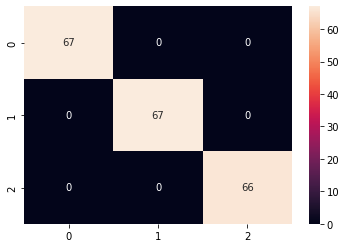

In [104]:
# Confusion Matrix

conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)

sns.heatmap(conf_matrix, annot = True)
plt.show()

In [105]:
# Classification Metrics

precision = metrics.precision_score(y_test, y_test_pred, average = 'weighted')
recall = metrics.recall_score(y_test, y_test_pred, average = 'weighted')
f1 = metrics.f1_score(y_test, y_test_pred, average = 'weighted')

print("Precision :", precision)
print("Recall or Sensitivity :", recall)
print("F1 Score :", f1)

Precision : 1.0
Recall or Sensitivity : 1.0
F1 Score : 1.0


In [106]:
# Classification Report

clf_report = metrics.classification_report(y_train, y_train_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       267
           1       0.99      1.00      0.99       266
           2       1.00      0.97      0.98       267

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



#### Cross Validation

In [108]:
scores = model_selection.cross_val_score(svm.LinearSVC(), X_train, y_train, cv = 10)

print(np.sum(scores) / len(scores))

0.9887500000000001
